# Part 2: Generate Features and Run Model

In [2]:
# %matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import pinv, svd
from scipy.sparse.linalg import svds
from ipynb.fs.defs.preprocess_data import metadata, load_dataset, grid_to_slices
from pathlib import Path
import dicom
import torch
import torch.utils.data

from itertools import filterfalse

### Define function for generating features
We define the function for generating the transition matrix and flattening into a row of features.

In [3]:

# data should be 4 dimensions: time, vertical slice, height, width
# dtype
#  inputs: torch.FloatTensor
#  labels: torch.LongTensor
# shape
#  inputs: torch.Size([1, 65, 1, 100, 116, 116]) --> 1, time slice, 1, vertical slices, height,width
#  labels: torch.Size([1])
# q is number of singular values we're concerned with
# This will return a concatenated vector of the state transition matrix (q*q) for each vertical slice
# So length of return vector is q * q * num_vertical_slices
def calculate_transition_models(data, q = 10):
    frames = data.shape[1]
    vertical_slices = data.shape[3]
    height = data.shape[4]
    width = data.shape[5]

    state_transitions = np.zeros(q * q * vertical_slices)
    for slice_num in range(vertical_slices):
        slice_data = data[0,:,0,slice_num,:,:]
        Y = np.zeros((height * width, frames))
        for i in range(frames):
            frame = slice_data[i].numpy().reshape(height * width)
            Y[:,i] = frame

        U, E, V_t = svds(Y, k=q)
        V = V_t.T
        C = U[:,:q]
        Ehat = np.diag(E[:q])
        Vhat = V[:,:q]
        X = Ehat.dot(Vhat.T)

        x1 = np.zeros((q, frames - 1))
        x2 = np.zeros((q, frames - 1))
        for i in range(x1.shape[1]):
            for j in range(q):
                x1[j,i] = X[j,i]
                x2[j,i] = X[j,i + 1]

        x1_pinv = pinv(x1)
        A = x2.dot(x1_pinv)
        state_transition = A.reshape(q*q)

        start_index = q * q * slice_num
        end_index =  q * q * (slice_num+1)
        state_transitions[start_index:end_index] = state_transition
    return state_transitions


### Generate Features
Iterate through dataset, generate features and save to csv file. First for Linear Dynamical Systems Features and second for Tensor Decomposition.

In [34]:

train_DF = pd.DataFrame()
count = 0

for i, (x, y) in enumerate(load_dataset('./data', shuffle=False)):
    if isinstance(x, torch.FloatTensor) and x.shape[1]==65:
        print(x.type(), x.size())
        transition_features = calculate_transition_models(x)
        target = y.numpy()
        line = np.append(transition_features, target)
        train_DF = train_DF.append(pd.Series(line), ignore_index=True)
        train_DF.to_csv(path_or_buf="./data/output/LDS_features.csv", index_label=False, header=False)
    else:
        print("not!", x.type(), x.size())
        pass


torch.FloatTensor torch.Size([1, 65, 1, 100, 116, 116])


In [35]:
import tensorly as tl
from tensorly.decomposition import parafac, tucker, partial_tucker
import tensorflow as tf

tl.set_backend('pytorch')
print(torch.cuda.is_available())
data_dir = './data/'

train_tensor_DF = pd.DataFrame()
count = 0


for i, (x, y) in enumerate(load_dataset(data_dir, shuffle=False)):
    if isinstance(x, torch.FloatTensor) and x.shape[1]==65:
        
        x=x.view(1,65,100,116,116)
        print(tl.context(x))
        core, factors = tucker(x, ranks=[1,10,10,10,10], init='random', tol=10e-5, verbose=False)
        transition_features = core.numpy().flatten()
        target = y.numpy()
        line = np.append(transition_features, target)
        train_tensor_DF = train_tensor_DF.append(pd.Series(line), ignore_index=True)
    else:
        print("not!", x.type(), x.size())
        
        continue
train_tensor_DF.to_csv(path_or_buf="./data/output/TD_features.csv", index_label=False, header=False)



False


Using pytorch backend.


{'dtype': torch.float32, 'device': device(type='cpu'), 'requires_grad': False}


### Fit ensemble models
We import our generated features and perform dimensionality reduction. We also initialize several classifiers to fit to the 'multiple' data sets we've generated. We use these to then produce predictions to measure accuracy and f-measure.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

df_array = np.genfromtxt("./TD_features.csv", dtype=float, delimiter=',')
kpca = KernelPCA(n_components=10, kernel='rbf')
X_orig = df_array[:,1:-1]
y_orig = df_array[:,-1]

ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X_orig, y_orig)


X_kpca = kpca.fit_transform(X)


clf = RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.1, min_samples_leaf=1, min_samples_split=9, n_estimators=100)
clf_kpca = RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.1, min_samples_leaf=1, min_samples_split=9, n_estimators=100)

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) 
x_kpca_train, x_kpca_test, y_kpca_train, y_kpca_test = train_test_split(X_kpca,y, test_size=0.2, random_state=42) 

clf.fit(x_train, y_train)
clf_kpca.fit(x_kpca_train, y_kpca_train)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features=0.1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=9, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [37]:
y_pred = clf.predict(x_test)
y_kpca_pred = clf_kpca.predict(x_kpca_test)

kpca_var = kpca.lambdas_


In [38]:
from sklearn.metrics import f1_score, accuracy_score
f_measure = f1_score(y_test, y_pred)
f_measure_kpca = f1_score(y_kpca_test, y_kpca_pred)


acc = accuracy_score(y_test, y_pred)
acc_kpca = accuracy_score(y_kpca_test, y_kpca_pred)

print("PCA v. LDA\tf_measure\t\taccuracy")
print("- \t\t"+str(round(f_measure, 3))+"\t\t\t"+str(round(acc,3)))
print("kPCA  \t\t"+str(round(f_measure_kpca, 3))+"\t\t\t"+str(round(acc_kpca,3)))


PCA v. LDA	f_measure		accuracy
- 		0.941			0.938
kPCA  		0.941			0.938


### Visualizing results

We would also like to visualize the results we've obtained. Particularly we want to see how the variance is distributed differently as well as the general feature distribution between the three dimensionality reduction techniques that were implemented.

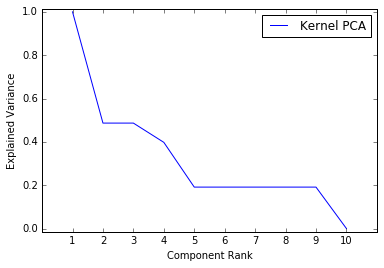

In [32]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
kpca_var = kpca_var.reshape(-1,1)
kpca_var_ratio = mm.fit_transform(kpca_var)

plt.figure()
plt.plot(range(1,11),kpca_var_ratio, label="Kernel PCA", )
plt.axis([0, 11, -0.015, 1.015])
plt.xticks(np.arange(1, 11, 1.0))
plt.ylabel("Explained Variance")
plt.xlabel("Component Rank")
plt.legend()
plt.savefig("explained_variance.png", dpi=500, bboxinches=2)
plt.show()